<a href="https://colab.research.google.com/github/williamfaraday123/AIFileReader/blob/main/Lim_Isaac_Part_A_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.3** to each of the hidden layers.

In [1]:
!wget https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/common_utils.py -O common_utils.py

--2026-02-26 05:54:26--  https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/common_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2153 (2.1K) [text/plain]
Saving to: ‘common_utils.py’

common_utils.py     100%[===================>]   2.10K  --.-KB/s    in 0s      

2026-02-26 05:54:26 (22.7 MB/s) - ‘common_utils.py’ saved [2153/2153]



In [5]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [12]:
class MLP(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [7]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    # Extract labels from 'filename'. Assuming filename contains 'positive' or 'negative'
    # Or if the filename itself is the label, encode it.
    # Adjust the lambda function below based on how the CSV represents labels.
    df['label'] = df['filename'].apply(lambda x: 1 if 'pos' in x.lower() else 0)

    X = df.drop(columns=['filename', 'label']).values
    y = df['label'].values

    # Split dataset (75:25)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Scaling features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch Tensors
    X_train_scaled = torch.tensor(X_train, dtype=torch.float32)
    y_train_scaled = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_scaled = torch.tensor(X_test, dtype=torch.float32)
    y_test_scaled = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/simplified.csv')

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [8]:
df['label'].value_counts()

,count
label,
1,6202
0,5855


#### Use the training dataset to train the model for 200 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.0005**, weight decay of **0.0005** and **batch size = 64**. Implement early stopping with patience of **5**.

3.Define a Pytorch Dataset and Dataloaders.  

In [9]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        # Ensure y is a 2D tensor (column vector) for BCELoss
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    # Create instances of the CustomDataset
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    # Initialize DataLoaders
    # Note: Training loader uses shuffle=True for better gradient descent
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

/tmp/ipython-input-1115/2125272639.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


4.Next, define the model, optimizer and loss function.

In [13]:
# YOUR CODE HERE
input_dim = X_train_scaled.shape[1]
model = MLP(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
loss_fn = nn.BCELoss()

5.Train model for 200 epochs. Record down train and test accuracies. Implement early stopping.

In [14]:
# YOUR CODE HERE
epochs = 200
patience = 5
best_loss = np.inf
counter = 0

history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_losses = []
    correct_train = 0
    total_train = 0

    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = (outputs > 0.5).float()
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_y.size(0)

    # --- EVALUATION PHASE (Using test_dataloader) ---
    model.eval()
    test_losses = []
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader:
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            test_losses.append(loss.item())
            preds = (outputs > 0.5).float()
            correct_test += (preds == batch_y).sum().item()
            total_test += batch_y.size(0)

    # Calculate Epoch Metrics
    avg_train_loss = np.mean(train_losses)
    avg_train_acc = correct_train / total_train
    avg_test_loss = np.mean(test_losses)
    avg_test_acc = correct_test / total_test

    # Store in history
    history['train_loss'].append(avg_train_loss)
    history['test_loss'].append(avg_test_loss)
    history['train_acc'].append(avg_train_acc)
    history['test_acc'].append(avg_test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {avg_test_acc:.4f}")

    # Early Stopping Logic (based on averaged test loss)
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1/200 | Train Loss: 0.6875 | Test Loss: 0.6790 | Test Acc: 0.5672
Epoch 2/200 | Train Loss: 0.6744 | Test Loss: 0.6671 | Test Acc: 0.5947
Epoch 3/200 | Train Loss: 0.6644 | Test Loss: 0.6559 | Test Acc: 0.6060
Epoch 4/200 | Train Loss: 0.6565 | Test Loss: 0.6503 | Test Acc: 0.6149
Epoch 5/200 | Train Loss: 0.6454 | Test Loss: 0.6363 | Test Acc: 0.6355
Epoch 6/200 | Train Loss: 0.6368 | Test Loss: 0.6286 | Test Acc: 0.6474
Epoch 7/200 | Train Loss: 0.6289 | Test Loss: 0.6215 | Test Acc: 0.6547
Epoch 8/200 | Train Loss: 0.6144 | Test Loss: 0.6162 | Test Acc: 0.6610
Epoch 9/200 | Train Loss: 0.6086 | Test Loss: 0.6079 | Test Acc: 0.6653
Epoch 10/200 | Train Loss: 0.5996 | Test Loss: 0.6024 | Test Acc: 0.6760
Epoch 11/200 | Train Loss: 0.5906 | Test Loss: 0.5874 | Test Acc: 0.6952
Epoch 12/200 | Train Loss: 0.5794 | Test Loss: 0.5815 | Test Acc: 0.7008
Epoch 13/200 | Train Loss: 0.5705 | Test Loss: 0.5751 | Test Acc: 0.7061
Epoch 14/200 | Train Loss: 0.5642 | Test Loss: 0.5732 | Test

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


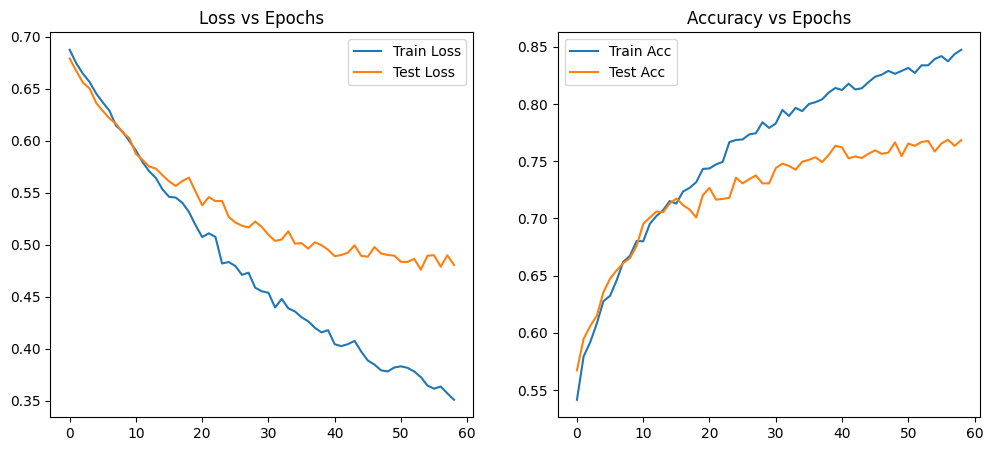

In [15]:
# YOUR CODE HERE
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['test_acc'], label='Test Acc')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

6.Comment on line plots.

In [16]:
# YOUR CODE HERE
answer = "Both train loss and test loss decrease, but they diverge more and more as number of epochs increases. Both train and test accuracy increase but they diverge as the number of epochs increases. The model is learning, but with increasing overfitting.\nAs the number of epochs increases beyond 40, the test loss and test accuracy plateau but the train loss continues to decrease. This means the model has reached its maximum generalisation capacity, and the optimal time for early stopping is at 40 epochs."
print(answer)

Both train loss and test loss decrease, but they diverge more and more as number of epochs increases. Both train and test accuracy increase but they diverge as the number of epochs increases. The model is learning, but with increasing overfitting.
As the number of epochs increases beyond 40, the test loss and test accuracy plateau but the train loss continues to decrease. This means the model has reached its maximum generalisation capacity, and the optimal time for early stopping is at 40 epochs.
